# <center>EMEA hackathon Q2 2020. Modelling</center>

### Description
Use of universal pixels are becoming more and more popular to improve efficiency and drive revenue. Universal pixel or tag is a code snippet which can be placed across a website and track users’ actions. This information collected from tracking can be used for tracking conversions or building audiences.

The goal of 2020 Q2 EMEA hackathon is to familiarise yourself with the data from universal pixel and make a prediction if a user is in a high value segment. The data comes from one of our clients. A high value segment is a group of users that are highly likely to take a specific action that is valuable to the client such as purchasing a product. Between these users there are commonalities that you could investigate to make your prediction.

### Data structure
| Field | Description |
|:-------|:-------------|
| **date_time** | The time and date of the universal pixel fire |
| **user_id_64** | User id |
| **url** |	The entire URL of the page the pixel is on |
| **http_referer** | The entire URL of the referrer to the page the pixel is on |
| **event**	| The event associated with the pixel fire |
| **item_ids**	| Strings passed in on the item_id parameter within your pixel |
| **item_types** |	Strings passed in on the item_type parameter within your pixel |
| **item_names** | Strings passed in on the item_name parameter within your pixel |
| **segment_id** | The list of IDs for the segments the user was added to as a result of the universal pixel firing |
| **segment_name** | Name of a segment |
| **conversion_pixel_ids** | The list of IDs for the conversion events triggered by the user as a result of the universal pixel firing |
| **partition_time_millis** | The hourly partition any record row falls into |
| **event_value** |	The nominal value of the event |

### Evaluation metric and results
The competition metric was **F1 score**

Top 3 submission results:

    1)  0.615
    2)  0.607
    3)  0.598
    
The goal of these notebooks is to explore the dataset and to see where the score could be improved.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
from sklearn.metrics import f1_score

test_labels = pd.read_csv('GroundTruth/Perfect Preds.csv')
display(test_labels.shape)

# Function to evaluate prediction on the test dataset
def evaluate_preds(pred):
    return f1_score(test_labels.pred.values, pred)

(10280, 2)

## Catboost model on prepared data

In [203]:
df = pd.read_hdf('all_data.h5', 'data')
print(df.shape)
df.head(3)

(51400, 628)


,user_id,event_AddPaymentInfo,event_ItemView,event_Lead,event_PageView,item_types_['acc-dash:dashboard how-to overlay:video play'],item_types_['bp content:overlay:cta click:brochures'],item_types_['bp content:single feature:cta click:brochures'],item_types_['bp:360:maximise view:exterior'],item_types_['bp:360:minimise view:exterior'],...,conversion_pixel_ids_[1207834],conversion_pixel_ids_[1217482],conversion_pixel_ids_[],target,test,n_sessions,n_pages,month,hour,item_ids_unique
0,'1',0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0,0,0.0,1.146128,6,evening,1
1,'10',0.0,15.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,-1,1,0.0,1.301030,4,evening,0
2,'100',0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0,0,0.0,1.079181,5,morning,1


In [224]:
from sklearn.preprocessing import StandardScaler

# I'm going to use StandardScaler to apply RidgeClassifier for feature selection 
scaler = StandardScaler()

# consider month and hour as categorical variables, so add them later
cols_to_transform = df.columns[~df.columns.isin(['user_id', 'target', 'test', 'month', 'hour'])].tolist()

# fit on the training dataset
scaler.fit(df.loc[df.test==0, cols_to_transform])

# transform features and add 'month' and 'hour' at the end as categorical ones
X_train = pd.DataFrame(scaler.transform(df.loc[df.test==0, cols_to_transform]), columns=cols_to_transform)
X_train = pd.concat([X_train, df.loc[df.test==0, ['month', 'hour']].reset_index(drop=True).apply(lambda x: x.apply(lambda y: str(y)))],
                   axis=1)
y_train = df.loc[df.test==0, 'target'].values

X_test = pd.DataFrame(scaler.transform(df.loc[df.test==1, cols_to_transform]), columns=cols_to_transform)
X_test = pd.concat([X_test, df.loc[df.test==1, ['month', 'hour']].reset_index(drop=True).apply(lambda x: x.apply(lambda y: str(y)))],
                   axis=1)

print(X_train.shape, y_train.shape, X_test.shape)

(41120, 625) (41120,) (10280, 625)


### Feature selection

In [227]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

# train on all except the 'month' and 'hour' features
gscv = GridSearchCV(RidgeClassifier(),
                    param_grid={'alpha':np.logspace(-1, 1, 6),
                                'class_weight':[{0:x, 1:(1-x)} for x in np.linspace(0.22, 0.3, 5)]},
                    scoring='f1',
                    cv=5,
                    n_jobs=-1,
                    verbose=1).fit(X_train.loc[:, X_train.columns[:-2]], y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


In [228]:
gscv.best_params_
#gscv.best_score_

{'alpha': 0.6309573444801934, 'class_weight': {0: 0.22, 1: 0.78}}

In [229]:
# F1 score on the test dataset
evaluate_preds(gscv.best_estimator_.predict(X_test.loc[:, X_test.columns[:-2]]))

0.5341545352743561

/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


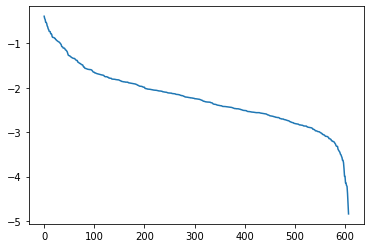

In [230]:
# Distribution of coefficient weights

plt.plot(np.log10(np.sort(abs(gscv.best_estimator_.coef_))[0][::-1]))

431

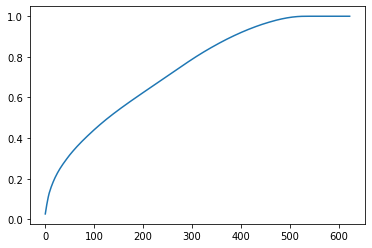

In [231]:
# how many features to select

from sklearn.decomposition import PCA

pca = PCA().fit(X_train.loc[:, X_train.columns[:-2]])

display(np.max(np.where(pca.explained_variance_ratio_.cumsum() < 0.95)[0]))
plt.plot(pca.explained_variance_ratio_.cumsum())

In [242]:
from sklearn.feature_selection import SelectFromModel

# select best features from RidgeClassifier model. Adjust the threshold value to get about 431 features
selector = SelectFromModel(gscv.best_estimator_, threshold=3e-3, prefit=True)

X_new = X_train.loc[:, X_train.columns[:-2][selector.get_support()].tolist() + ['month', 'hour']]
X_test_new = X_test.loc[:, X_test.columns[:-2][selector.get_support()].tolist() + ['month', 'hour']]
print(X_new.shape, X_test_new.shape)

(41120, 407) (10280, 407)


### Explore model parameter ranges

In [243]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_new, y_train, test_size=0.33, stratify=y_train, random_state=99)
train_pool = Pool(X_tr, y_tr, cat_features=[405, 406])
valid_pool = Pool(X_val, y_val, cat_features=[405, 406])

train_full = Pool(X_new, y_train, cat_features=[405, 406])
test_pool = Pool(X_test_new, cat_features=[405, 406])

In [259]:
ctb = CatBoostClassifier(iterations=1000,
                         learning_rate=0.05,
                         depth=6,
                         thread_count=-1,
                         loss_function='Logloss',
                         class_weights={0:0.32, 1:0.68},
                         eval_metric='F1').fit(train_pool, silent=True)

f1_score(y_val, ctb.predict(valid_pool))

0.5904186447993094

### Hyperparameter tuning

In [268]:
ctb = CatBoostClassifier(iterations=800,
                            learning_rate=0.05,
                            depth=5,
                            thread_count=-1,
                            loss_function='Logloss',
                            class_weights={0:0.3, 1:0.7},
                            eval_metric='F1')

model = GridSearchCV(ctb,
                     param_grid={'iterations':[800, 900, 1000],
                                 'depth':[6, 7, 8],
                                 'class_weights':[{0:x, 1:(1-x)} for x in np.linspace(0.22, 0.32, 6)]},
                     scoring='f1',
                     cv=5,
                     n_jobs=-1).fit(X_new, y_train, cat_features=[405, 406], silent=True)

/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [271]:
print(model.best_params_)
print(model.best_score_)

{'class_weights': {0: 0.28, 1: 0.72}, 'depth': 7, 'iterations': 900}
0.5946089337265947


### Evaluation on the test dataset

In [273]:
evaluate_preds(model.best_estimator_.predict(test_pool))

0.6171875000000001

### Top 20 features

In [275]:
model.best_estimator_.get_feature_importance(prettified=True).iloc[:20]

,Feature Id,Importances
0,n_pages,18.040009
1,segment_name_UK_Owner_OSB vehicle info_all,10.213665
2,month,4.201613
3,event_ItemView,2.789447
4,hour,2.774897
5,n_sessions,2.592242
6,event_PageView,2.307444
7,conversion_pixel_ids_[],2.133993
8,item_types_['brand:build:initiate'],2.105325
9,segment_name_Unknown/No Segment,1.982414
